In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import timesfm


2024-06-08 06:31:06.856095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Load and parse data

In [2]:
filename = "../data/pbc2.csv"
df = pd.read_csv(filename)
df.rename(columns = {'status2' : 'label'}, inplace=True)
FEATURE_COLUMNS = ['year','serBilir','albumin',
             'alkaline', 'SGOT', 'platelets', 
             'prothrombin']
FEATURE_WITHOUT_YEAR = ['serBilir','albumin',
             'alkaline', 'SGOT', 'platelets', 
             'prothrombin']

<BarContainer object of 15 artists>

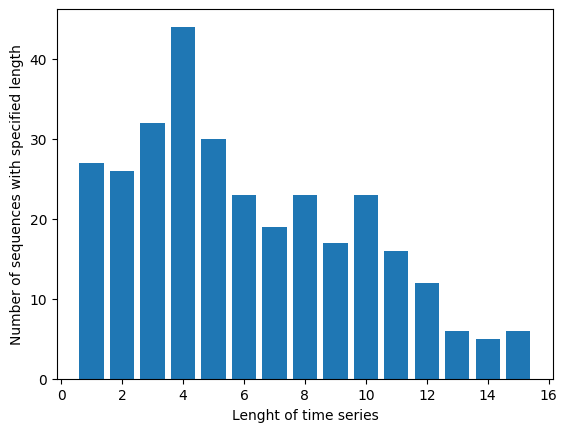

In [3]:
l_nb = [(df.id.value_counts() == i).value_counts()[True] for i in range(1,16)]
x = np.arange(1,16)
fig, ax = plt.subplots()
ax.set_xlabel('Lenght of time series')
ax.set_ylabel('Number of sequences with specified length')
plt.bar(x,l_nb)

In [4]:
df.isna().sum()

Unnamed: 0        0
id                0
years             0
status            0
drug              0
age               0
sex               0
year              0
ascites          60
hepatomegaly     61
spiders          58
edema             0
serBilir          0
serChol         821
albumin           0
alkaline         60
SGOT              0
platelets        73
prothrombin       0
histologic        0
label             0
dtype: int64

In [5]:
sequences = []

for series_id, group in df.groupby('id'):
    sequences_features = group[FEATURE_COLUMNS]
    label = group.iloc[0].label
    sequences.append([sequences_features, label])

In [6]:
def prepadding_dataframe(df_list, max_len):
    df_cols = df_list[0][0].columns.to_list()
    for i in range(len(df_list)):
        padd_length = max_len - len(df_list[i][0]['year'])
        padding_df = pd.DataFrame(
            0., index=range(padd_length), columns = df_cols)
        df_list[i][0] = pd.concat([padding_df, df_list[i][0]])
    return df_list

paddeds_df = prepadding_dataframe(sequences, 16)

In [45]:
testing_uknow = paddeds_df[1][0]
testing_uknow.iloc[0:15]
testing_uknow.iloc[15]

year             8.832548
serBilir         4.600000
albumin          2.670000
alkaline       669.000000
SGOT            88.000000
platelets      100.000000
prothrombin     11.500000
Name: 10, dtype: float64

In [55]:
import datetime
from dateutil.relativedelta import relativedelta
formatted = pd.DataFrame(columns=['unique_id','ds','data'])

time_array = []
id_array = []
val_array = []


val_names = ['serBilir','albumin','alkaline','SGOT','platelets','prothrombin']
for e in val_names:
    time_array += testing_uknow['year'].iloc[0:15].to_list()
    id_array += 15*[e]
    val_array += testing_uknow[e].iloc[0:15].to_list()

first_date = pd.to_datetime('2000-01-01')
# pd.DateOffset(month=int((time*12)%12))
datetime_array = [first_date + relativedelta(months=int(time*12)) for time in time_array]

formatted.unique_id = id_array
formatted.ds = datetime_array
formatted.data = val_array
formatted

,unique_id,ds,data
0,serBilir,2000-01-01,0.0
1,serBilir,2000-01-01,0.0
2,serBilir,2000-01-01,0.0
3,serBilir,2000-01-01,0.0
4,serBilir,2000-01-01,0.0
...,...,...,...
85,prothrombin,2002-02-01,10.6
86,prothrombin,2004-11-01,11.3
87,prothrombin,2005-11-01,11.5
88,prothrombin,2006-11-01,11.5


In [57]:
last_date = first_date + relativedelta(months=int(testing_uknow.year.iloc[15]*12))
print(f"Date : {last_date}")
print(f"Expected result : {testing_uknow.iloc[15]}")

Date : 2008-10-01 00:00:00
Expected result : year             8.832548
serBilir         4.600000
albumin          2.670000
alkaline       669.000000
SGOT            88.000000
platelets      100.000000
prothrombin     11.500000
Name: 10, dtype: float64


In [58]:
import timesfm

tfm = timesfm.TimesFm(
    context_len=32,
    horizon_len=10,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='cpu',
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")
forecast_df = tfm.forecast_on_df(
    inputs=formatted,
    freq="Y",
    value_name="data",
    num_jobs=-1,
)
print(forecast_df)

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.00 seconds.
Restoring checkpoint from /home/leo/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.23 seconds.
Jitting decoding.
Jitted decoding in 23.86 seconds.
Processing dataframe with multiple processes.


2024-06-08 08:13:50.859242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-08 08:13:50.860434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-08 08:13:50.861015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-08 08:13:50.864769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-08 08:13:50.867224: W tensorflow/stream_executor/platform/default/dso_lo

Finished preprocessing dataframe.
Finished forecasting.
      unique_id         ds      timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0          SGOT 2007-12-31   120.986664      92.833115     104.983597   
1          SGOT 2008-12-31   118.480309      77.462448      94.218117   
2          SGOT 2009-12-31   118.663025      71.388428      88.819519   
3          SGOT 2010-12-31   115.106453      66.016426      84.942909   
4          SGOT 2011-12-31   114.823845      58.315380      79.552475   
5          SGOT 2012-12-31   109.710777      50.963646      73.212914   
6          SGOT 2013-12-31   105.978905      48.049522      69.761230   
7          SGOT 2014-12-31   102.345642      40.335125      62.008549   
8          SGOT 2015-12-31   102.028694      39.015759      62.641438   
9          SGOT 2016-12-31   101.187149      37.866859      61.695953   
10      albumin 2007-12-31     2.872331       2.204067       2.455491   
11      albumin 2008-12-31     2.768403       1.843485       2.22168

/home/leo/miniconda3/envs/tfm_env/lib/python3.10/site-packages/utilsforecast/processing.py:374: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/leo/miniconda3/envs/tfm_env/lib/python3.10/site-packages/utilsforecast/processing.py:428: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
